In [1]:
import numpy as np
import torch
import torch.nn.functional as F

from RnaVeloDataset import RnaVeloDataset
from symsimDataset import SymsimBifur, SymsimTree, SymsimBranch, SymsimLinear, SymsimCycle, SymsimTrifur, SymsimNoVeloTree, SymsimNewNoVeloBranch, SymsimOldNoVeloTree

from torch_geometric.data import DataLoader, Data
from model.BaseModel import BaseModel
from sklearn.metrics import mean_squared_error
from unsupervised_loss import UnsupervisedLoss
from model.mymodel import MyModel, GraphSAGEModel, FCModel, veloModel, DiffusionModel
from math import sqrt
import utils
import backbone

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# dataBifur = SymsimBifur()
dataTree = SymsimTree()
# dataTrifur = SymsimTrifur()
# dataBranch = SymsimBranch()
dataLinear = SymsimLinear()
# dataCircle = SymsimCycle()
dataTreeNoVelo = SymsimNoVeloTree()
dataTreeOldNoVelo = SymsimOldNoVeloTree()
dataBranchNoVelo = SymsimNewNoVeloBranch()
print(len(dataBranchNoVelo))
print(dataBranchNoVelo.num_features)

50
299


In [ ]:
from sklearn.kernel_ridge import KernelRidge
clf = KernelRidge(alpha=0.1)
clf.fit(X, y)

In [31]:
def get_loss_sage(node_embed, train_nodes, data, pos_size=5, neg_size=10):
    pos_idx = torch.where(torch.Tensor(data['pos_neighbor'][0]) == 1)
    pos_score = F.cosine_similarity(node_embed[pos_idx[0],:], node_embed[pos_idx[1],:])
    pos_score = torch.log(torch.sigmoid(pos_score))
    pos_score = torch.mean(-pos_score)
    return pos_score

In [32]:
def get_loss_time(time, data):
    pos_idx = torch.where(torch.Tensor(data['pos_neighbor'][0]) == 1)
    score = F.pairwise_distance(time[pos_idx[0]], time[pos_idx[1]])
    score = torch.mean(score)
    return score

In [3]:
def train(model, train_loader, lamb = None, time_lamb = None, train_loss = 'pearson'):
    model.train()

    total_loss = total_loss_objective = total_loss_net = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        output, node_embed, adj = model(data)
        loss = 0

        if lamb:
            train_nodes = torch.arange(adj.shape[0])
            loss_net = lamb * get_loss_sage(node_embed, train_nodes, data, pos_size=5, neg_size=10)
            loss += loss_net
            total_loss_net += loss_net

        if time_lamb:
            loss_net = time_lamb * get_loss_time(output, data)
            loss += loss_net
            total_loss_net += loss_net

        label = data.y.to(device)
        loss_objective = 0

        if train_loss == 'pearson':
            vx = output - torch.mean(output)
            vy = label - torch.mean(label)
            loss_objective += -torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2)))
        if train_loss == 'rmse':
            loss_objective += torch.sqrt(F.mse_loss(output, label))

        loss += loss_objective
        total_loss_objective += loss_objective

        loss.backward()
        total_loss += loss
        optimizer.step()

    return float(total_loss / len(train_loader.dataset)), float(total_loss_objective / len(train_loader.dataset)), float(total_loss_net / len(train_loader.dataset))

def test(model, loader):
    model.eval()
    
    correct = []
    predict = []
    neg_pearson_loss = 0
    for data in loader:
        data = data.to(device)
        label = data.y.detach().cpu().numpy().reshape(-1)
        pred,_,_ = model(data)
        pred = pred.detach().cpu().numpy().reshape(-1)
        neg_pearson_loss += utils.pearson(pred, label)

    neg_pearson_loss = - neg_pearson_loss / len(loader)

    return neg_pearson_loss

In [32]:
t = np.arange(8)
train_mask = []
val_mask = []
train_mask = list(t) + list(t+10) + list(t+20) + list(t+30) + list(t+40)
# train_mask = list(t) + list(t+10)
val_mask = [8, 9, 18, 19, 28, 29, 38, 39, 48, 49]
# val_mask = [8, 9, 18, 19]
# for i in range(2):
#     train_mask += list(t + 10*i)
# val_mask.append(10*i)

In [35]:
# data_train = torch.utils.data.ConcatDataset([dataLinear[train_mask], dataTree[train_mask]])
# data_val = torch.utils.data.ConcatDataset([dataLinear[val_mask], dataTree[val_mask]])

data_train = dataTree[train_mask]
data_val = dataTree[val_mask]
print("Number of Train:", str(len(data_train)), "\nNumber of Val:", str(len(data_val)))

Number of Train:40
Number of Val:10


# Test Diffusion NN
On tree, linear, bifurcating, trifurcating

In [25]:
device

device(type='cuda')

In [36]:
# mask the dataset
train_loader = DataLoader(data_train, batch_size = 1, shuffle = True)
val_loader = DataLoader(data_val, batch_size = 1)

model = DiffusionModel(dataLinear.num_features, hidden1 = 256, hidden2 = 128, max_diffusion = 3, include_reversed = True, device = device, dropout1=0.2, dropout2=0.2).to(device)

# model = GraphSAGEModel(dataTree.num_features, device, h1 = 256, h2 = 128, dropout1 = 0.2, dropout2 = 0.2).to(device)

# reset parameters
model.reset_parameters()
print(model)

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-5, weight_decay=0.01)

train_list = []
val_list = []
for epoch in range(0, 41):

    train_loss, objective_loss, net_loss = train(model, train_loader, train_loss='rmse', lamb=None, time_lamb=None)
    train_acc = test(model, train_loader)
    val_acc = test(model, val_loader)

    log = 'Epoch: {:03d}, Loss: {:.4f}, Objective loss: {:.4f}, Regularization loss: {:.4f}, Train: {:.4f}, Val: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, train_loss, objective_loss, net_loss, train_acc, val_acc))
    
    train_list.append(train_acc)
    val_list.append(val_acc)

DiffusionModel(
  (conv1): GraphDiffusion (299 -> 256)
  (conv2): GraphDiffusion (256 -> 128)
  (lin): Linear(in_features=128, out_features=1, bias=True)
)
Epoch: 000, Loss: 0.2570, Objective loss: 0.2570, Regularization loss: 0.0000, Train: -0.3983, Val: -0.3916
Epoch: 010, Loss: 0.0829, Objective loss: 0.0829, Regularization loss: 0.0000, Train: -0.9517, Val: -0.8921
Epoch: 020, Loss: 0.0628, Objective loss: 0.0628, Regularization loss: 0.0000, Train: -0.9710, Val: -0.9084
Epoch: 030, Loss: 0.0522, Objective loss: 0.0522, Regularization loss: 0.0000, Train: -0.9797, Val: -0.9183
Epoch: 040, Loss: 0.0456, Objective loss: 0.0456, Regularization loss: 0.0000, Train: -0.9847, Val: -0.9234


In [37]:
for epoch in range(0, 41):

    train_loss, objective_loss, net_loss = train(model, train_loader, train_loss='rmse', lamb=None, time_lamb=None)
    train_acc = test(model, train_loader)
    val_acc = test(model, val_loader)

    log = 'Epoch: {:03d}, Loss: {:.4f}, Objective loss: {:.4f}, Regularization loss: {:.4f}, Train: {:.4f}, Val: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, train_loss, objective_loss, net_loss, train_acc, val_acc))
    
    train_list.append(train_acc)
    val_list.append(val_acc)

Epoch: 000, Loss: 0.0445, Objective loss: 0.0445, Regularization loss: 0.0000, Train: -0.9850, Val: -0.9249
Epoch: 010, Loss: 0.0396, Objective loss: 0.0396, Regularization loss: 0.0000, Train: -0.9880, Val: -0.9256
Epoch: 020, Loss: 0.0360, Objective loss: 0.0360, Regularization loss: 0.0000, Train: -0.9902, Val: -0.9288
Epoch: 030, Loss: 0.0332, Objective loss: 0.0332, Regularization loss: 0.0000, Train: -0.9917, Val: -0.9276
Epoch: 040, Loss: 0.0308, Objective loss: 0.0308, Regularization loss: 0.0000, Train: -0.9930, Val: -0.9308


In [38]:
def visualize_pt(ax, pt, model, label, X_pca, fig):
    loss = "  Pearson Correlation: " + str(utils.pearson(pt, label))[:5] if len(label) else ''
    pred_sorted = sorted(pt)
    pt = [pred_sorted.index(i) for i in pt]

    pseudo_visual = ax.scatter(X_pca[:,0], X_pca[:,1], c = pt, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax)    
    ax.set_title(model + loss)

def scatter(data, title, true_label=True, umap=False, dpt=False):

    X_pca = utils.pca_op(data.x.detach().numpy(), standardize=False)
    if umap:
        X_pca = data.adata.obsm['X_umap']

    fig = plt.figure(figsize=(7,5))
    ax4 = fig.subplots(1,1)

    fig.suptitle(title, fontsize=20)

    # DiffusionNN
    pt, _, _ = model(data.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
    visualize_pt(ax4, pt.detach().cpu().numpy().squeeze(), "DiffusionNN", "", X_pca, fig)

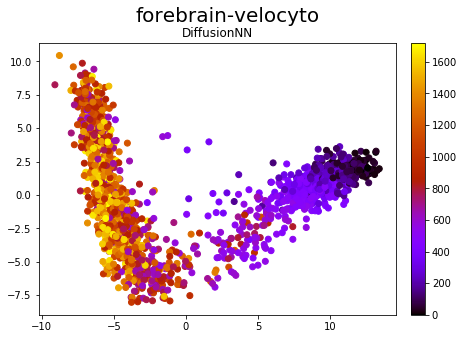

In [39]:
from realDataset import forebrainDataset, chromaffinDataset, forebrainDataset_large, peDataset, peDataset_large, paulDataset
import matplotlib.pyplot as plt
forebrain = forebrainDataset()
for data in DataLoader(forebrain):
    scatter(data, title='forebrain-velocyto', true_label=False)

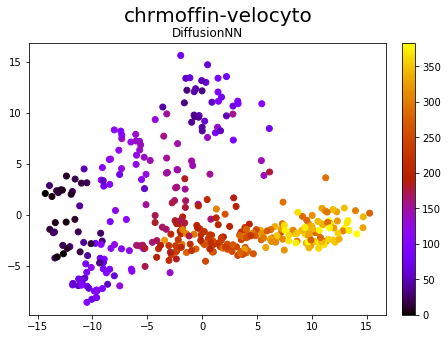

In [40]:
chromaffin = chromaffinDataset()
for data in DataLoader(chromaffin):
    scatter(data, title='chrmoffin-velocyto', true_label=False)

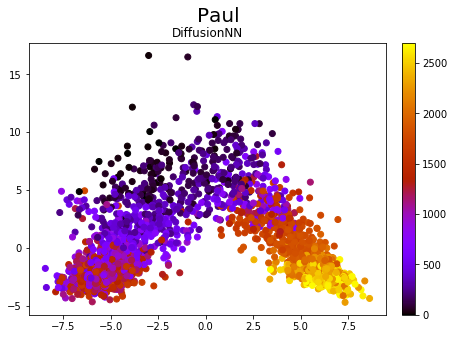

In [41]:
# without
paul = paulDataset()
for data in DataLoader(paul):
    X_pca = utils.pca_op(data.x.detach().numpy(), standardize=False)

    fig = plt.figure(figsize = (7, 5))
    ax4 = fig.subplots(1,)

    fig.suptitle('Paul', fontsize=20)

    # DiffusionNN
    pt, _, _ = model(data.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
    visualize_pt(ax4, pt.detach().cpu().numpy().squeeze(), "DiffusionNN", [], X_pca, fig)

In [16]:
Path = "./trained_model/Diffusion_symnewnovtreebranch_256_128_3_2_2_4454.pt"
torch.save(model.state_dict(), Path)

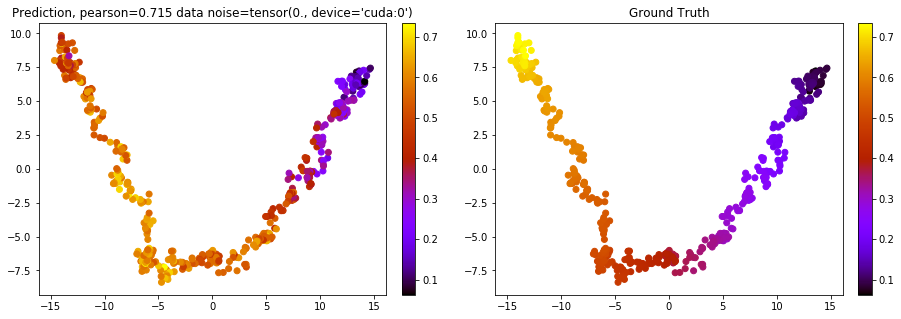

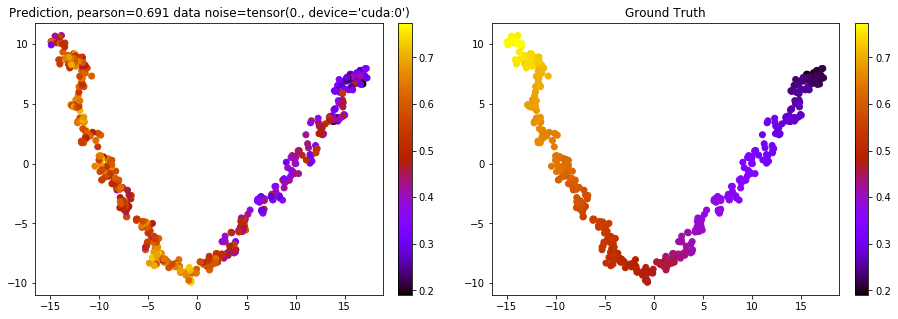

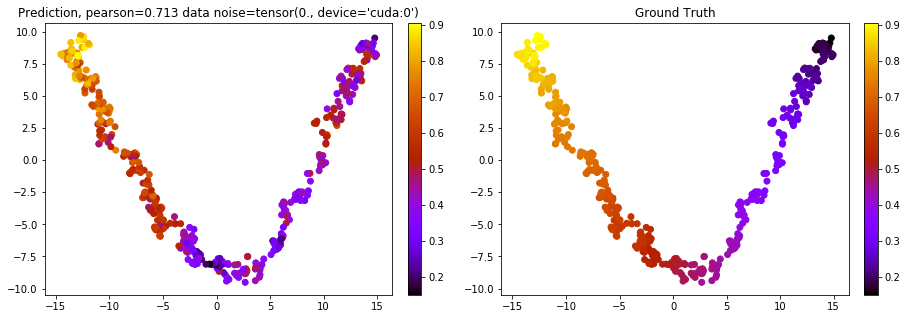

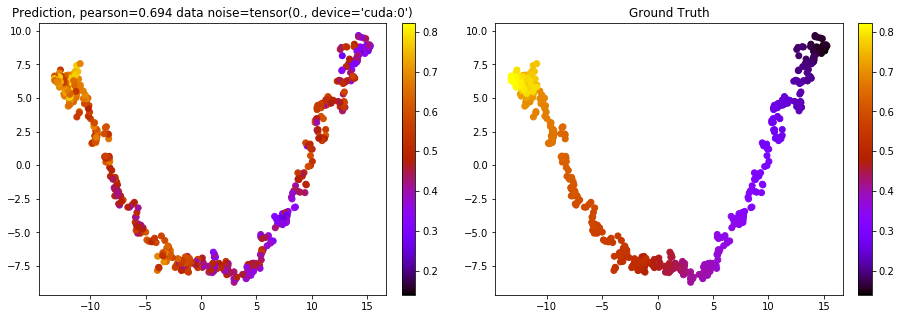

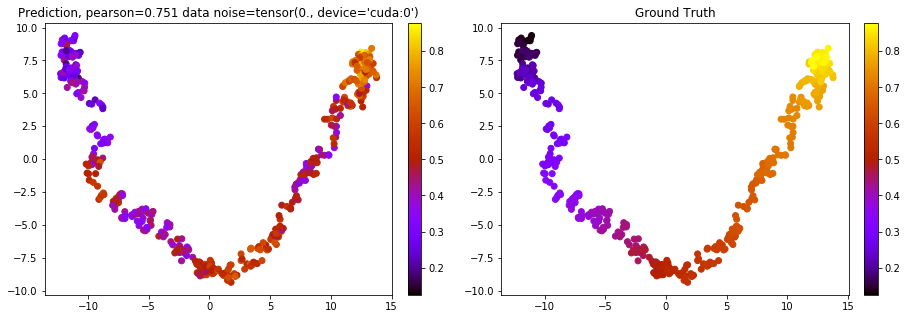

In [32]:
for data in val_loader:
    utils.scatter(model, data, method='pca', coloring='raw', metric='pearson', knn=False, device=device)

## GraphSAGE

In [15]:
model_sage = GraphSAGEModel(dataDyngen.num_features, device, h1 = 256, h2 = 128, dropout1 = 0.2, dropout2 = 0.2).to(device)

# reset parameters
model_sage.reset_parameters()
print(model)

optimizer = torch.optim.Adam(params=model_sage.parameters(), lr=5e-5, weight_decay=0.01)

train_list = []
val_list = []
for epoch in range(0, 81):

    train_loss, objective_loss, net_loss = train(model_sage, train_loader, train_loss='rmse', lamb=None, time_lamb=None)
    train_acc = test(model_sage, train_loader)
    val_acc = test(model_sage, val_loader)

    log = 'Epoch: {:03d}, Loss: {:.4f}, Objective loss: {:.4f}, Regularization loss: {:.4f}, Train: {:.4f}, Val: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, train_loss, objective_loss, net_loss, train_acc, val_acc))
    
    train_list.append(train_acc)
    val_list.append(val_acc)

DiffusionModel(
  (conv1): GraphDiffusion (299 -> 256)
  (conv2): GraphDiffusion (256 -> 128)
  (lin): Linear(in_features=128, out_features=1, bias=True)
)
Epoch: 000, Loss: 0.2851, Objective loss: 0.2851, Regularization loss: 0.0000, Train: -0.1661, Val: -0.0504
Epoch: 010, Loss: 0.2392, Objective loss: 0.2392, Regularization loss: 0.0000, Train: -0.4750, Val: -0.2599
Epoch: 020, Loss: 0.2194, Objective loss: 0.2194, Regularization loss: 0.0000, Train: -0.5875, Val: -0.2871
Epoch: 030, Loss: 0.2062, Objective loss: 0.2062, Regularization loss: 0.0000, Train: -0.6509, Val: -0.2919
Epoch: 040, Loss: 0.1974, Objective loss: 0.1974, Regularization loss: 0.0000, Train: -0.6916, Val: -0.3046
Epoch: 050, Loss: 0.1900, Objective loss: 0.1900, Regularization loss: 0.0000, Train: -0.7204, Val: -0.3010
Epoch: 060, Loss: 0.1831, Objective loss: 0.1831, Regularization loss: 0.0000, Train: -0.7485, Val: -0.2892
Epoch: 070, Loss: 0.1760, Objective loss: 0.1760, Regularization loss: 0.0000, Train: -0

In [17]:
Path = "./trained_model/GraphSAGE_symnewnovtreebranch_299_256_128_3_2_2_2685.pt"
torch.save(model_sage.state_dict(), Path)

In [16]:
Path = "./trained_model/GraphSAGE_299_2_2.pt"

# model = DiffusionModel(dataTree.num_features, hidden1 = 256, hidden2 = 128, max_diffusion = 6, include_reversed = True, device = device, dropout1=0.2, dropout2=0.2).to(device)
model = GraphSAGEModel(dataTree.num_features, device, h1 = 256, h2 = 128, dropout1 = 0.2, dropout2 = 0.2).to(device)

model.load_state_dict(torch.load(Path, map_location=torch.device('cpu')))
model.eval()

GraphSAGEModel(
  (conv1): GraphConvolutionSage (299 -> 256)
  (conv2): GraphConvolutionSage (256 -> 128)
  (lin): Linear(in_features=128, out_features=1, bias=True)
)

# Test Fully connected NN
On both linear, tree, bifurcating and real dataset, without velocity

**Too test if FC NN can work in linear structure, new dataset is needed, as current branch test is meaningless for FC NN**

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_fc = FCModel(dataDyngen.num_features, device, hidden1=256, hidden2=128, dropout1=0.2, dropout2=0.2).to(device)

train_loader = DataLoader(data_train, batch_size = 1, shuffle = True)
val_loader = DataLoader(data_val, batch_size = 1)

# reset parameters|
# model_fc.reset_parameters()
print(model_fc)

optimizer = torch.optim.Adam(params=model_fc.parameters(), lr=5e-5, weight_decay=0.01)

train_list = []
val_list = []
for epoch in range(201):

    train_loss, _, _ = train(model_fc, train_loader, train_loss='rmse')
    train_acc = test(model_fc, train_loader)
    val_acc = test(model_fc, val_loader)
    log = 'Epoch: {:03d}, Loss: {:.4f}, Train: {:.4f}, Val: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, train_loss, train_acc, val_acc))
    
    train_list.append(train_acc)
    val_list.append(val_acc)

FCModel(
  (lin1): Linear(in_features=299, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=128, bias=True)
  (lin3): Linear(in_features=128, out_features=1, bias=True)
)
Epoch: 000, Loss: 0.2836, Train: -0.1834, Val: -0.1058
Epoch: 010, Loss: 0.2341, Train: -0.5352, Val: -0.3273
Epoch: 020, Loss: 0.2056, Train: -0.6607, Val: -0.2912
Epoch: 030, Loss: 0.1909, Train: -0.7211, Val: -0.2618
Epoch: 040, Loss: 0.1817, Train: -0.7538, Val: -0.2660
Epoch: 050, Loss: 0.1734, Train: -0.7850, Val: -0.2523
Epoch: 060, Loss: 0.1644, Train: -0.8123, Val: -0.2558
Epoch: 070, Loss: 0.1564, Train: -0.8346, Val: -0.2513
Epoch: 080, Loss: 0.1479, Train: -0.8593, Val: -0.2418
Epoch: 090, Loss: 0.1410, Train: -0.8727, Val: -0.2632
Epoch: 100, Loss: 0.1336, Train: -0.8891, Val: -0.2272
Epoch: 110, Loss: 0.1277, Train: -0.8974, Val: -0.2413
Epoch: 120, Loss: 0.1239, Train: -0.9087, Val: -0.2318
Epoch: 130, Loss: 0.1189, Train: -0.9136, Val: -0.2184
Epoch: 140, Loss: 0.1159, Train:

In [19]:
Path = "./trained_model/Linear_symnewnovtreebranch_299_256_128_2_2_1758.pt"
torch.save(model_fc.state_dict(), Path)

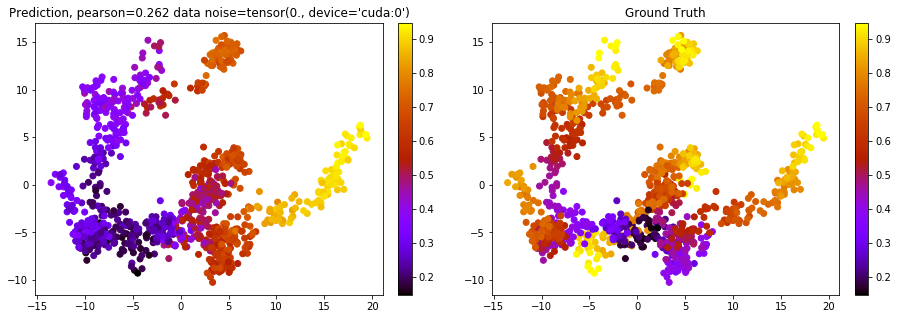

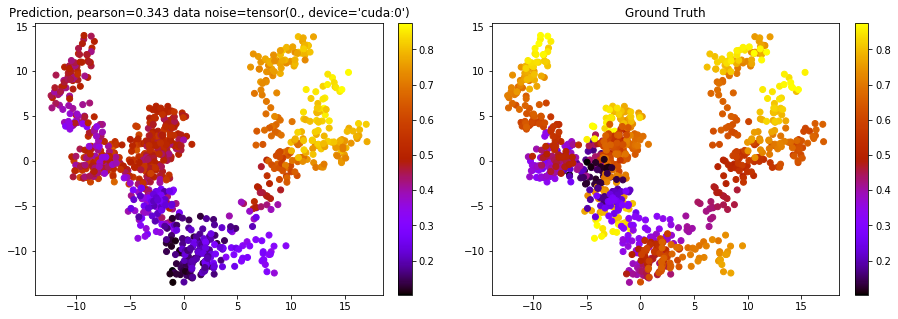

In [18]:
val_loader = DataLoader(data_val, batch_size = 1)

for data in val_loader:
    utils.scatter(model, data, method='pca', coloring='raw', metric='pearson', knn=False, device=device)

In [11]:
import scanpy as sc
real_file = "./data/real_dataset/"
cell_annot = pd.read_csv(real_file + "Paul_cell_meta.txt", sep="\t")
expr = pd.read_csv(real_file + "Paul_expr.txt", sep="\t")
adata = anndata.AnnData(X=expr.T, obs = cell_annot)
sc.pp.filter_genes(adata, min_counts = 20)
sc.pp.normalize_per_cell(adata)
sc.pp.filter_genes_dispersion(adata, n_top_genes= 300)
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.umap(adata)

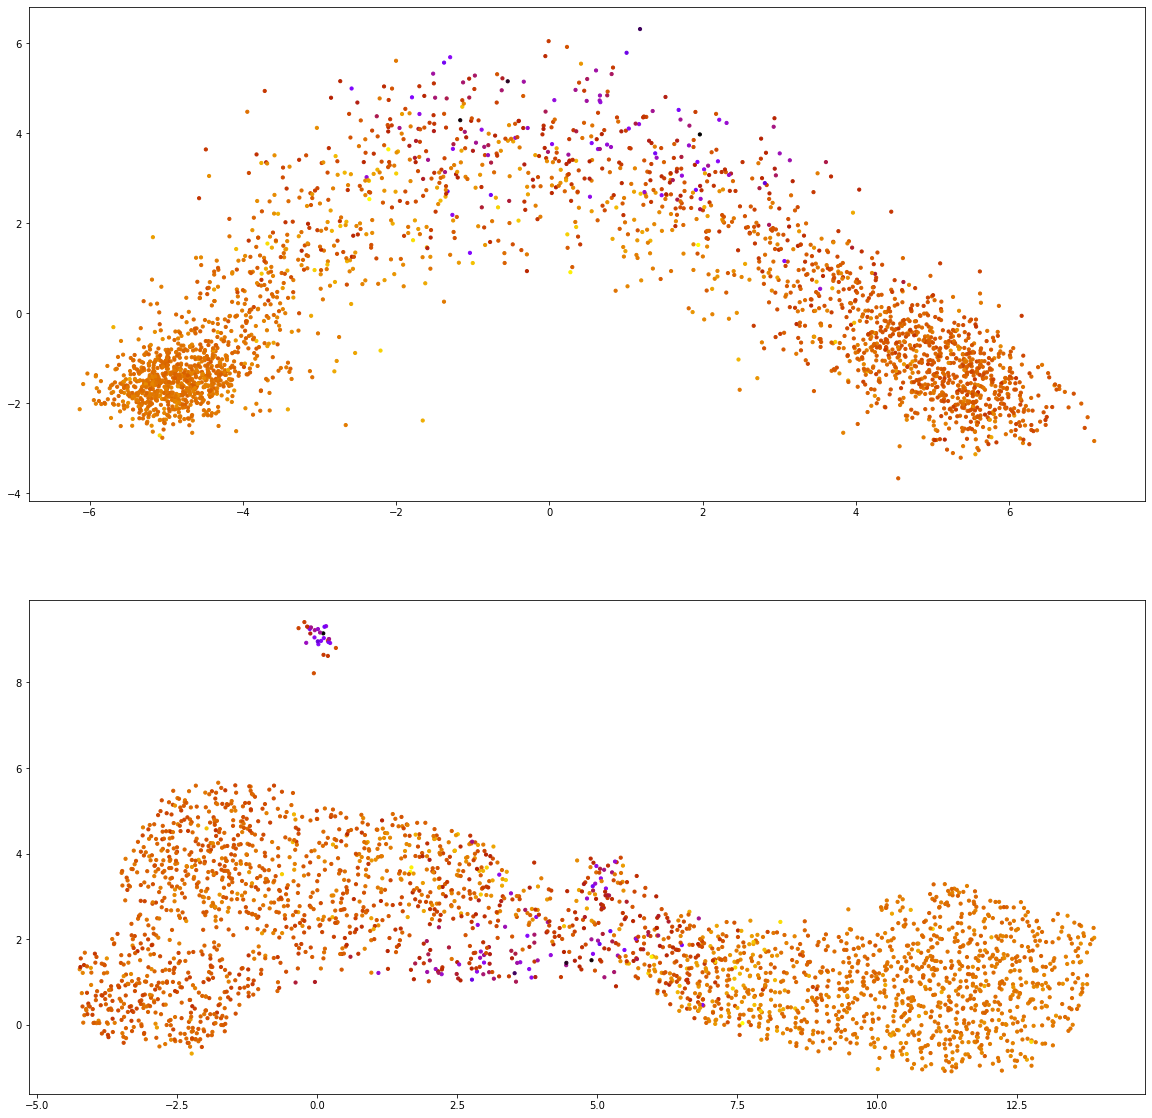

In [14]:
other_index = ~(adata.obs["cell_type2"] == 'Multipotent progenitors').values

X_spliced = adata.X
# X_spliced is original, X_pca is after pca
x = X_spliced.copy()
x = StandardScaler().fit_transform(x)
x = torch.FloatTensor(x)
data = Data(x=x)
# X should be something before pca
X = data.x.numpy()

X_pca = adata.obsm['X_pca']
X_umap = adata.obsm['X_umap']

data = data.to(device)
pred,_,_ = model(data)
pred = pred.detach().cpu().numpy().reshape(-1)


fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(20,20))
ax1.scatter(X_pca[:,0],X_pca[:,1], cmap = 'gnuplot', c = pred, s = 10)
# ax1.scatter(X_pca[other_index,0],X_pca[other_index,1], color = "gray", s = 15)

ax2.scatter(X_umap[:,0], X_umap[:,1], cmap = 'gnuplot', c = pred, s = 10)
# ax2.scatter(X_umap[other_index,0],X_umap[other_index,1], color = "gray", s = 15)

# ax1.scatter(X_pca[:,0],X_pca[:,1], cmap = 'gnuplot', color = adata.obs['cell_type2'].to_numpy())
plt.show()

In [54]:
def slingshot_visual(data, results, trajs = None, show_pcurve = True, figsize = (20,10), save_as = None):
    X = data.x.numpy()
    X_pca = utils.pca_op(X, n_comps = 2, standardize=False)
    label = data.y.numpy().squeeze()

    if trajs == None:
        trajs = results['pseudotime'].shape[1]
    ncols = np.ceil(trajs).astype('int32')
    nrows = 1
    fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize)
    fig.suptitle("slingshot pseudo-time", fontsize = 18)
    for i in range(trajs):
        if nrows == 1 or ncols == 1:
            if nrows == 1 and ncols == 1:
                ax = axs
            else:
                ax = axs[i]
        else:
            ax = axs[i%nrows, i//nrows]
        ax.scatter(X_pca[:,0],X_pca[:,1], color = 'gray', alpha = 0.1)
        if show_pcurve:
            # for curve in results['curves']:
            ax.plot(results['curves'][i,:,0],results['curves'][i,:,1],color = 'black')

        cells = results['pseudotime'].iloc[:,i]
        # eliminate `cell` in the string
        cells_index = [x for x in cells.index if not np.isnan(cells[x])]
        ordering = [x for x in cells[cells_index].sort_values().index]

        pred = [np.nanmean(x) for x in results["pseudotime"].values]

        vx = pred - np.mean(pred)
        vy = label - np.mean(label)
        pearson = np.sum(vx * vy) / (np.sqrt(np.sum(vx ** 2)) * np.sqrt(np.sum(vy ** 2)))

        X_traj = X_pca[ordering,:]

        pseudo_visual = ax.scatter(X_traj[:,0],X_traj[:,1],c = np.arange(X_traj.shape[0]), cmap=plt.get_cmap('gnuplot'),alpha = 0.7)
        fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax)
        ax.set_title("reconstructed trajectory " + str(i))
        fig.suptitle("Pearson correlationship: "+ str(pearson))
    if save_as != None:
        fig.savefig(save_as)
    plt.show()    
    return pearson 

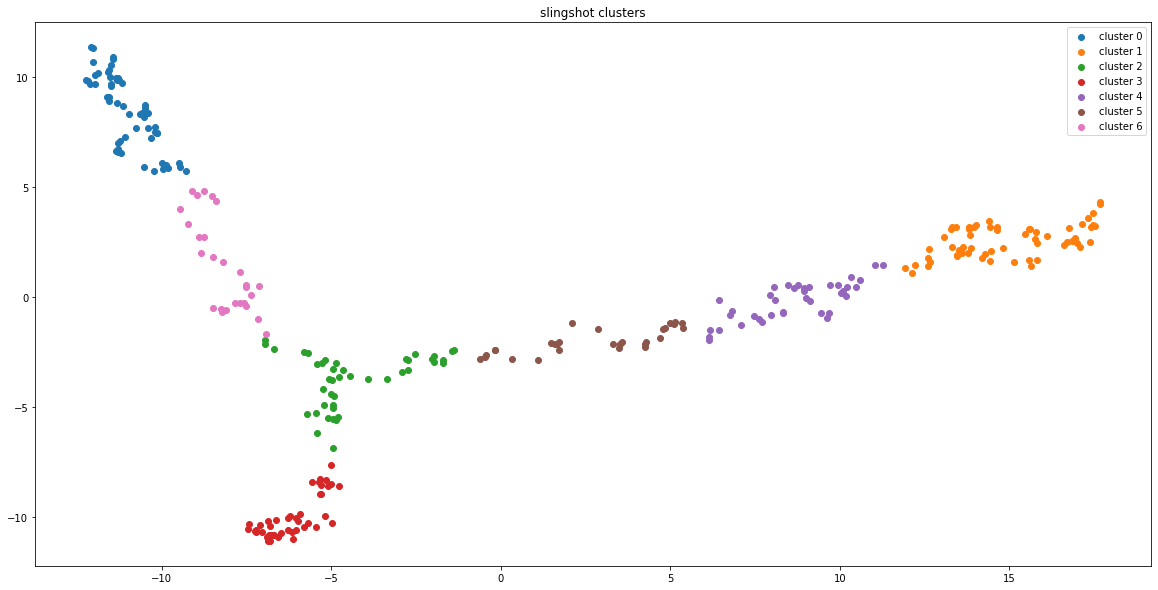

In [57]:
X = data_bifur.x.numpy()
X_pca = utils.pca_op(X, n_comps = 2, standardize=False)
from sklearn.cluster import KMeans
n_clusters = 7
init = "k-means++"
n_init = 10
max_iter = 300
tol = 0.0001
kmeans = KMeans(n_clusters, init, n_init, max_iter, tol)
groups = kmeans.fit_predict(X_pca)

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
# c_range = [eval(x) if isinstance(x, str) else x for x in adata.obs['sim_time']]
clusters = int(np.max(groups)+1)
for i in range(clusters):
    sub_cells = np.where(groups == i)[0]
    progression = ax.scatter(X_pca[sub_cells,0], X_pca[sub_cells,1], cmap = plt.get_cmap('Pastel1'))

ax.legend(['cluster '+ str(i) for i in range(clusters)])
ax.set_title("slingshot clusters")

X_pca_df = pd.DataFrame(columns= np.arange(X_pca.shape[1]), data = X_pca)

R[write to console]: Using full covariance matrix


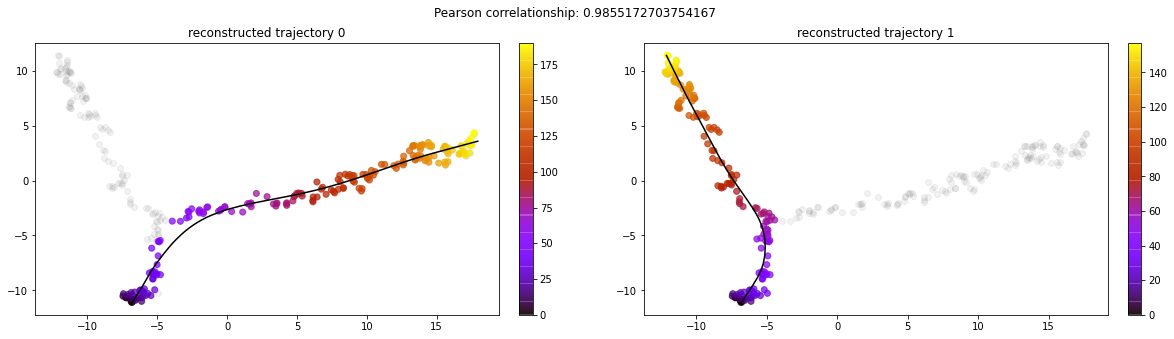

0.9855172703754167

In [60]:
results = scprep.run.Slingshot(X_pca_df, groups, start_cluster = 3)
slingshot_visual(data_bifur, results, trajs = None, show_pcurve = True, figsize = (20,5), save_as = None)

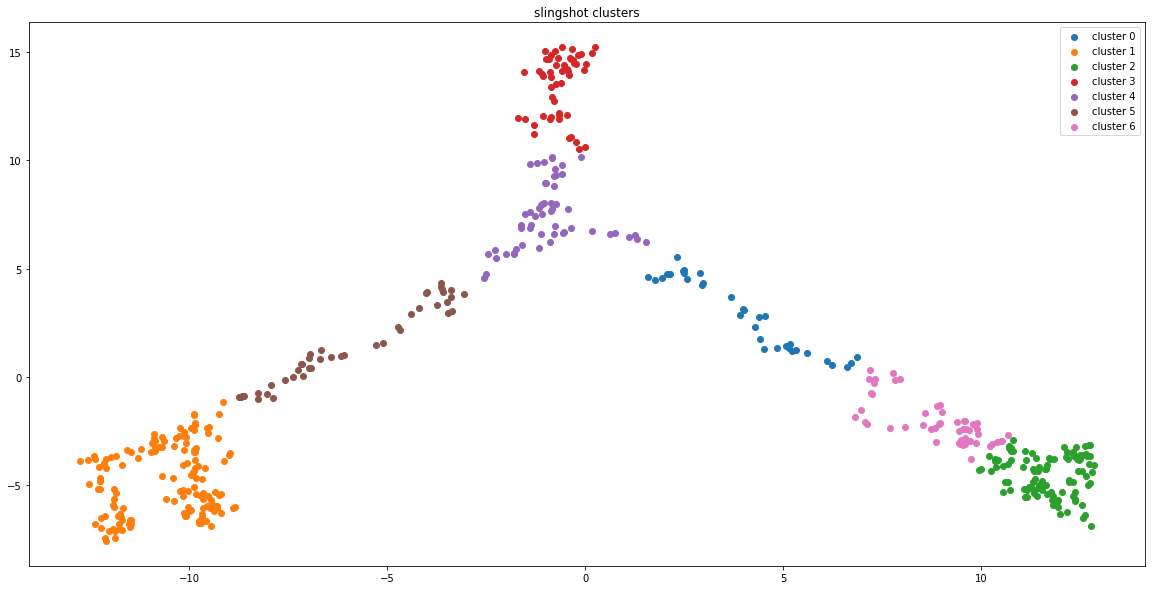

In [61]:
X = data_tree.x.numpy()
X_pca = utils.pca_op(X, n_comps = 2, standardize=False)
from sklearn.cluster import KMeans
n_clusters = 7
init = "k-means++"
n_init = 10
max_iter = 300
tol = 0.0001
kmeans = KMeans(n_clusters, init, n_init, max_iter, tol)
groups = kmeans.fit_predict(X_pca)

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
# c_range = [eval(x) if isinstance(x, str) else x for x in adata.obs['sim_time']]
clusters = int(np.max(groups)+1)
for i in range(clusters):
    sub_cells = np.where(groups == i)[0]
    progression = ax.scatter(X_pca[sub_cells,0], X_pca[sub_cells,1], cmap = plt.get_cmap('Pastel1'))

ax.legend(['cluster '+ str(i) for i in range(clusters)])
ax.set_title("slingshot clusters")

X_pca_df = pd.DataFrame(columns= np.arange(X_pca.shape[1]), data = X_pca)

R[write to console]: Using full covariance matrix


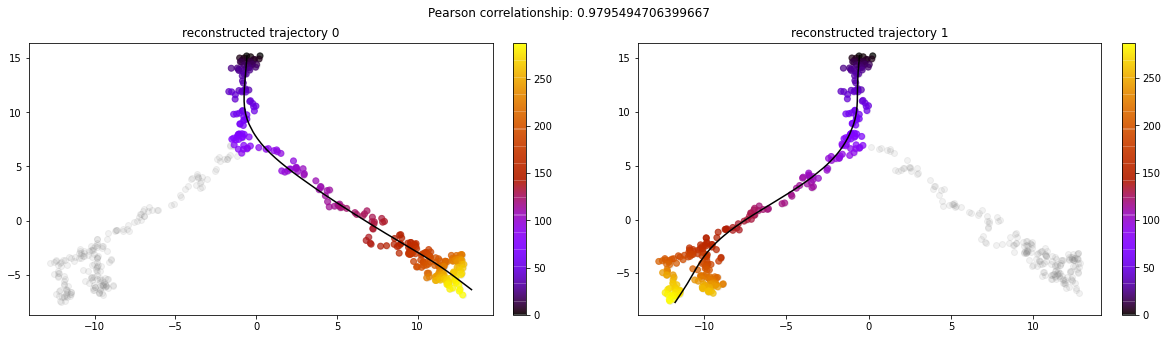

0.9795494706399667

In [64]:
results = scprep.run.Slingshot(X_pca_df, groups, start_cluster = 3)
slingshot_visual(data_tree, results, trajs = None, show_pcurve = True, figsize = (20,5), save_as = None)

In [10]:
data = dataTree[1]
X = data.x.numpy()
# note that the dimension cannot be too small
X_pca = utils.pca_op(X, n_comps=30, standardize=False)
y = data.y.numpy().squeeze()
# typical length of random walk is 100-150, result robust to the window size, step_size
randwk = backbone.random_walk(X_pca, y, t_max = 10000, i_max = 100, k = 5)

# segment
seg = backbone.segmentation(randwk, X_pca[:,:3], cell_backbone=data.bbs.rename_categories([0,1,2,3,4,5,6]), wind_size = 10, step = 2, y = y)
# cluster
cluster = seg['seg_backbone']

# connection
adj = backbone.retrieve_conn(seg, cluster)
T = backbone.post_processing_graph(adj)
T

array([[0, 1, 1, 0, 0, 0, 0],
       [1, 0, 0, 1, 1, 0, 0],
       [1, 0, 0, 0, 0, 1, 1],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0]])

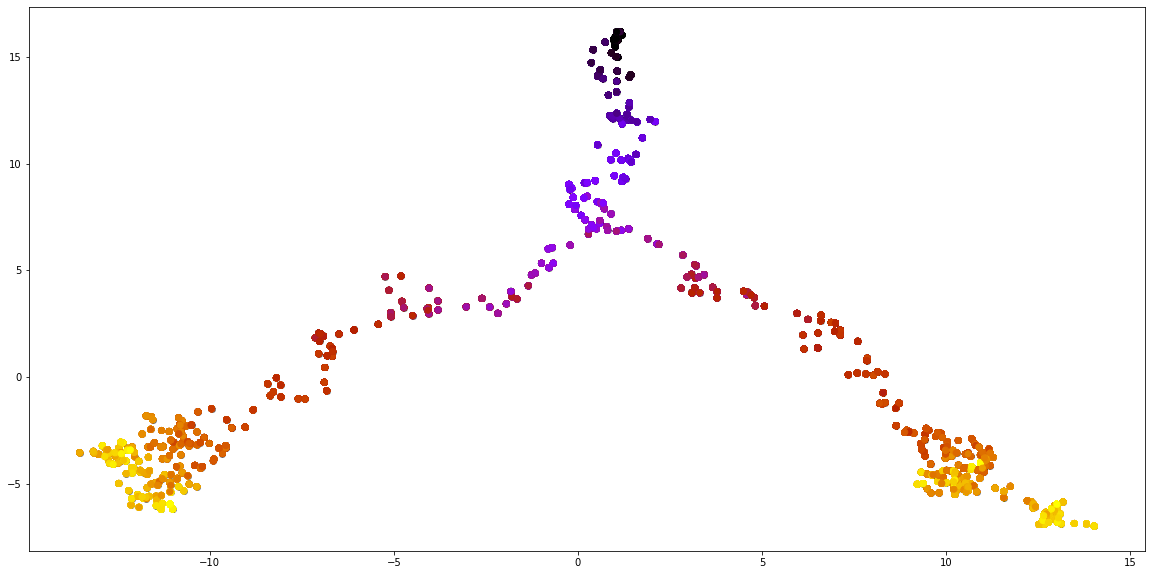

In [15]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(X_pca[:,0], X_pca[:,1], color = 'gray')
for i in range(1000):
    randwk_i = randwk[i]
    ax.scatter(X_pca[randwk_i,0], X_pca[randwk_i,1], c = np.arange(len(randwk_i)), cmap = plt.get_cmap('gnuplot'))

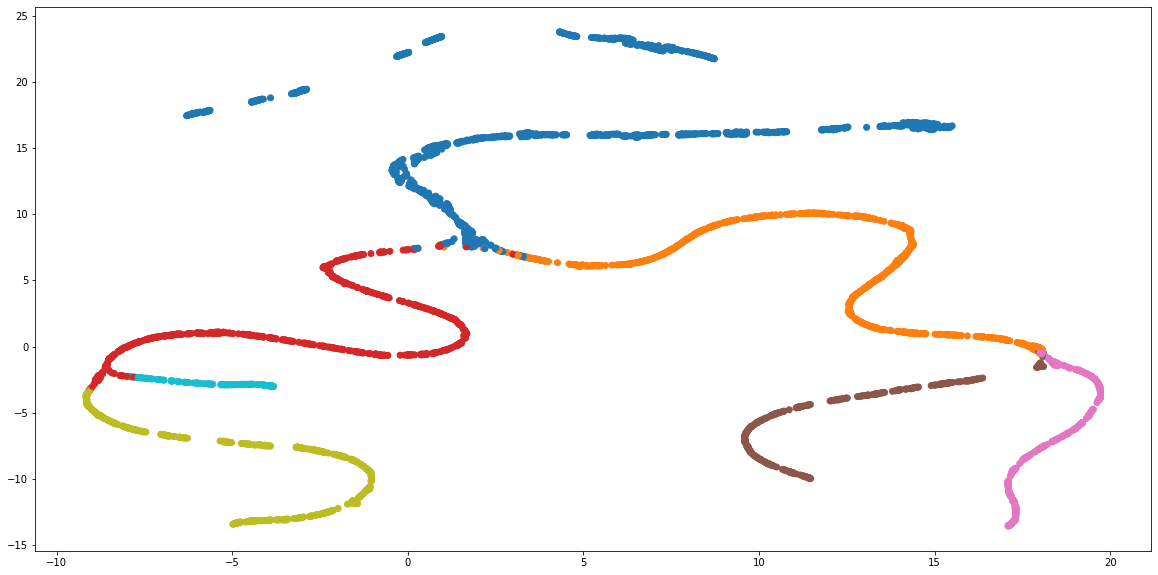

In [11]:
import umap
Umap = umap.UMAP(n_components = 2)
X_umap = Umap.fit_transform(np.array(seg['seg_features']))
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(X_umap[:,0], X_umap[:,1], c = seg['seg_backbone'], cmap = 'tab10')

In [24]:
for data in dataTree:
    print(data.x.shape)

torch.Size([590, 512])
torch.Size([582, 512])
torch.Size([576, 512])
torch.Size([599, 512])
torch.Size([572, 512])
torch.Size([599, 512])
torch.Size([559, 512])
torch.Size([595, 512])
torch.Size([579, 512])
torch.Size([568, 512])
torch.Size([576, 512])
torch.Size([529, 512])
torch.Size([629, 512])
torch.Size([621, 512])
torch.Size([607, 512])
torch.Size([592, 512])
torch.Size([590, 512])
torch.Size([574, 512])
torch.Size([595, 512])
torch.Size([552, 512])
torch.Size([575, 512])
torch.Size([596, 512])
torch.Size([630, 512])
torch.Size([608, 512])
torch.Size([560, 512])
torch.Size([586, 512])
torch.Size([587, 512])
torch.Size([554, 512])
torch.Size([554, 512])
torch.Size([565, 512])
torch.Size([600, 512])
torch.Size([612, 512])
torch.Size([577, 512])
torch.Size([592, 512])
torch.Size([601, 512])
torch.Size([581, 512])
torch.Size([590, 512])
torch.Size([560, 512])
torch.Size([570, 512])
torch.Size([558, 512])
torch.Size([632, 512])
torch.Size([615, 512])
torch.Size([571, 512])
torch.Size(

In [25]:
for data in dataTrifur:
    print(data.x.shape)

torch.Size([506, 512])
torch.Size([495, 512])
torch.Size([457, 512])
torch.Size([523, 512])
torch.Size([487, 512])
torch.Size([544, 512])
torch.Size([500, 512])
torch.Size([495, 512])
torch.Size([460, 512])
torch.Size([457, 512])
torch.Size([432, 512])
torch.Size([465, 512])
torch.Size([545, 512])
torch.Size([593, 512])
torch.Size([553, 512])
torch.Size([500, 512])
torch.Size([457, 512])
torch.Size([517, 512])
torch.Size([466, 512])
torch.Size([520, 512])
torch.Size([536, 512])
torch.Size([566, 512])
torch.Size([549, 512])
torch.Size([496, 512])
torch.Size([458, 512])
torch.Size([487, 512])
torch.Size([517, 512])
torch.Size([398, 512])
torch.Size([472, 512])
torch.Size([482, 512])
torch.Size([548, 512])
torch.Size([510, 512])
torch.Size([513, 512])
torch.Size([494, 512])
torch.Size([522, 512])
torch.Size([571, 512])
torch.Size([516, 512])
torch.Size([489, 512])
torch.Size([450, 512])
torch.Size([486, 512])
torch.Size([534, 512])
torch.Size([536, 512])
torch.Size([467, 512])
torch.Size(

In [26]:
for data in dataLinear:
    print(data.x.shape)

torch.Size([481, 512])
torch.Size([473, 512])
torch.Size([471, 512])
torch.Size([507, 512])
torch.Size([475, 512])
torch.Size([508, 512])
torch.Size([569, 512])
torch.Size([497, 512])
torch.Size([477, 512])
torch.Size([501, 512])
torch.Size([482, 512])
torch.Size([456, 512])
torch.Size([517, 512])
torch.Size([480, 512])
torch.Size([508, 512])
torch.Size([514, 512])
torch.Size([470, 512])
torch.Size([528, 512])
torch.Size([464, 512])
torch.Size([535, 512])
torch.Size([524, 512])
torch.Size([485, 512])
torch.Size([506, 512])
torch.Size([484, 512])
torch.Size([494, 512])
torch.Size([436, 512])
torch.Size([557, 512])
torch.Size([443, 512])
torch.Size([461, 512])
torch.Size([461, 512])
torch.Size([502, 512])
torch.Size([500, 512])
torch.Size([496, 512])
torch.Size([496, 512])
torch.Size([532, 512])
torch.Size([509, 512])
torch.Size([504, 512])
torch.Size([492, 512])
torch.Size([494, 512])
torch.Size([514, 512])
torch.Size([476, 512])
torch.Size([541, 512])
torch.Size([499, 512])
torch.Size(